# หัดใช้ Autoencoders ทำ CNN Image Denoising

เอกสารประกอบ
- https://www.kaggle.com/code/shivamb/how-autoencoders-work-intro-and-usecases
- https://www.kaggle.com/code/thomasdubail/auto-cnn/notebook
- https://blog.paperspace.com/understanding-autoencoders/
- https://idiotdeveloper.com/building-convolutional-autoencoder-using-tensorflow-2/

In [1]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model

from random import randint
import pandas as pd
import numpy as np

In [2]:
import os
from tqdm import tqdm
import cv2  
import numpy as np

from PIL import Image 

def load_data(foloder,class_names):
    """
        Load the data:
    """
    
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

    nb_classes = len(class_names)

    IMAGE_SIZE = (28, 28)
    
    
    
    datasets = [foloder]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            if('.DS_Store' in folder):
                continue
                
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):    
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        #images = np.array(images, dtype = 'float32')
        images = np.array(images, dtype = 'int')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append([images, labels])

    return output

In [114]:
class_names = ['circles', 'squares','triangles']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

output = load_data('../lab11/images',class_names = ['circles', 'squares','triangles'])

 85%|████████▌ | 85/100 [00:00<00:00, 835.63it/s]

Loading ../lab11/images


100%|██████████| 100/100 [00:00<00:00, 886.06it/s]


In [115]:
data,label = output[0]

In [116]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(data, label, random_state=22)
#train_images = train_images/255
train_images = train_images.astype('float32') / 255.0
train_images = np.dot(train_images[...,:3], [0.299, 0.587, 0.114])

In [117]:
def loadimage2arr(path):
    image = cv2.imread(path)
    IMAGE_SIZE = (28,28)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

In [118]:
def preview_examples(class_names, images, labels,maxdisplay=25):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples of images of the dataset", fontsize=16)
    for i in range(maxdisplay):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [119]:
#train_images = train_images - 1

In [120]:
train_images.min(),train_images.max()

(0.0313725508749485, 0.9999999999999999)

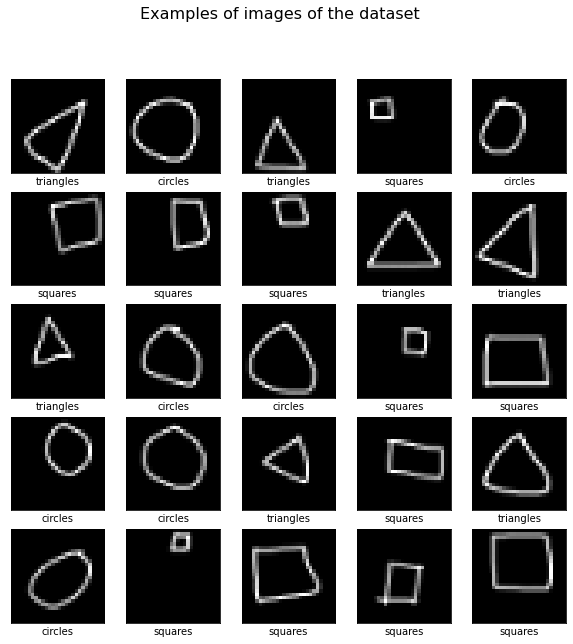

In [121]:
preview_examples(class_names,train_images,train_labels)

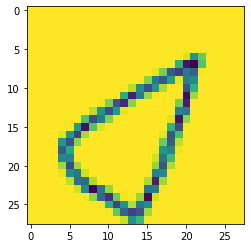

In [122]:
plt.imshow(train_images[0])

In [123]:
#train_images[0]# = np.where(train_images[0]<0,0,train_images[0])

In [124]:
train_images[0].min(),train_images[0].mean(),train_images[0].max()

(0.1921568661928177, 0.9411914785563642, 0.9999999999999999)

In [125]:
train_images.shape

(300, 28, 28)

In [126]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation, Cropping2D, Dense

from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU,Flatten,Reshape,Conv2DTranspose, LeakyReLU
import tensorflow as tf

from tensorflow.keras import initializers

In [216]:
H = 28
W = 28
C = 1

## Latent space
latent_dim = 512
inputs = Input(shape=(H, W, C), name="inputs")
x = inputs

x = Conv2D(32, (3, 3), padding="same",activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding="same",activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)


x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent",activation='relu')(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding="same",activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1, (3, 3), strides=2, padding="same",activation='relu')(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)


outputs = x

In [227]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
autoencoder.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_184 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu_211 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_185 (Bat (None, 14, 14, 64)        256

In [572]:
history = autoencoder.fit(train_images, train_images, 
          epochs=200, 
          batch_size=20,
          shuffle=True)

Epoch 1/200
15/15 [==============================] - 1s 69ms/step - loss: 3.7935e-05
Epoch 2/200
15/15 [==============================] - 1s 72ms/step - loss: 3.7124e-05
Epoch 3/200
15/15 [==============================] - 1s 84ms/step - loss: 3.7933e-05
Epoch 4/200
15/15 [==============================] - 1s 72ms/step - loss: 3.6170e-05
Epoch 5/200
15/15 [==============================] - 1s 84ms/step - loss: 3.8795e-05
Epoch 6/200
15/15 [==============================] - 1s 82ms/step - loss: 3.8488e-05
Epoch 7/200
15/15 [==============================] - 1s 84ms/step - loss: 3.7578e-05
Epoch 8/200
15/15 [==============================] - 1s 91ms/step - loss: 3.7856e-05
Epoch 9/200
15/15 [==============================] - 1s 71ms/step - loss: 3.9042e-05
Epoch 10/200
15/15 [==============================] - 1s 69ms/step - loss: 4.1551e-05
Epoch 11/200
15/15 [==============================] - 1s 74ms/step - loss: 4.0801e-05
Epoch 12/200
15/15 [==============================] - 1s 68ms/s

15/15 [==============================] - 1s 65ms/step - loss: 3.6681e-05
Epoch 97/200
15/15 [==============================] - 1s 64ms/step - loss: 3.6829e-05
Epoch 98/200
15/15 [==============================] - 1s 65ms/step - loss: 3.8983e-05
Epoch 99/200
15/15 [==============================] - 1s 65ms/step - loss: 3.8504e-05
Epoch 100/200
15/15 [==============================] - 1s 68ms/step - loss: 3.8429e-05
Epoch 101/200
15/15 [==============================] - 1s 64ms/step - loss: 3.9661e-05
Epoch 102/200
15/15 [==============================] - 1s 65ms/step - loss: 3.6265e-05
Epoch 103/200
15/15 [==============================] - 1s 71ms/step - loss: 3.6434e-05
Epoch 104/200
15/15 [==============================] - 1s 65ms/step - loss: 3.7760e-05
Epoch 105/200
15/15 [==============================] - 1s 64ms/step - loss: 3.4780e-05
Epoch 106/200
15/15 [==============================] - 1s 72ms/step - loss: 3.8401e-05
Epoch 107/200
15/15 [==============================] - 1s 64

15/15 [==============================] - 1s 67ms/step - loss: 3.5348e-05
Epoch 190/200
15/15 [==============================] - 1s 63ms/step - loss: 3.7050e-05
Epoch 191/200
15/15 [==============================] - 1s 64ms/step - loss: 3.6911e-05
Epoch 192/200
15/15 [==============================] - 1s 65ms/step - loss: 3.6047e-05
Epoch 193/200
15/15 [==============================] - 1s 67ms/step - loss: 3.7255e-05
Epoch 194/200
15/15 [==============================] - 1s 65ms/step - loss: 3.5393e-05
Epoch 195/200
15/15 [==============================] - 1s 63ms/step - loss: 3.5115e-05
Epoch 196/200
15/15 [==============================] - 1s 64ms/step - loss: 3.6947e-05
Epoch 197/200
15/15 [==============================] - 1s 68ms/step - loss: 3.5032e-05
Epoch 198/200
15/15 [==============================] - 1s 64ms/step - loss: 3.5131e-05
Epoch 199/200
15/15 [==============================] - 1s 68ms/step - loss: 3.5213e-05
Epoch 200/200
15/15 [==============================] - 1s

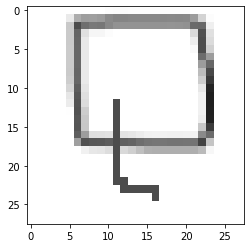

In [578]:
#โหลด file ทดสอบขึ้นมาดู ที่มี noise ใน images
name = 'noise06'
m1 = loadimage2arr(name+'.png')
plt.imshow(m1)  

In [579]:
m1.shape , train_images[0].shape

((28, 28, 3), (28, 28))

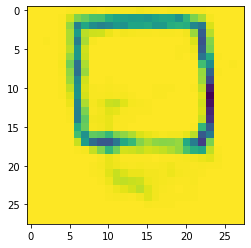

In [580]:
#ผลลัพธ์ เอาไปใส่ model

#m1_c = m1/255
m1_c = m1.astype('float32') / 255.0
m1_c = np.dot(m1_c[...,:3], [0.299, 0.587, 0.114])
#m1_c = m1_c - 1
#m1_c = m1_c.reshape(-1, 784)

predsTrain = autoencoder.predict(np.array([m1_c]))   #ดูผลลัพธ์ของ model
c = predsTrain[0].reshape(28,28,1)
plt.imshow(c)

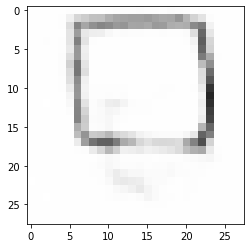

In [581]:
import matplotlib

k = c.reshape(28,28)
k = np.stack((k,)*3, axis=-1)
k = k*255
k = k.astype(np.uint8)
plt.imshow(k)
matplotlib.image.imsave('output'+name+'.png', k)

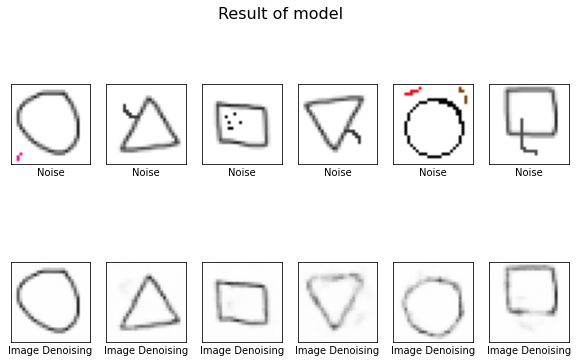

In [583]:
k = ['noise01.png','noise02.png','noise03.png',
     'noise04.png','noise05.png','noise06.png',
     'outputnoise01.png','outputnoise02.png','outputnoise03.png',
     'outputnoise04.png','outputnoise05.png','outputnoise06.png']
fig = plt.figure(figsize=(10,6))
fig.suptitle("Result of model", fontsize=16)
for i in range(len(k)):
    plt.subplot(2,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = loadimage2arr(k[i])
    plt.imshow(img, cmap=plt.cm.binary)
    if(i<6):
      plt.xlabel('Noise')
    else:
      plt.xlabel('Image Denoising')   
plt.show()